In [3]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# 加载CSV文件
df = pd.read_csv('./data/Dataset.csv')

# 对分类特征进行编码
categorical_features = [
'class'
]
le = LabelEncoder()
# 对每个分类特征进行编码
for feature in categorical_features:
    df[feature] = le.fit_transform(df[feature])

# 转换DataFrame为numpy数组，因为模型通常需要numpy数组或Tensor作为输入
data = df.values

# 分离特征和标签
X = data[:, :-1]  # 所有行，除了最后一列
y = data[:, -1]   # 所有行，只有最后一列


X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

# 分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 现在X_train和y_train用于训练模型，X_test和y_test用于测试模型
# 使用PyTorch DataLoader，将numpy数组转换为PyTorch的Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [4]:
# 归一化
from sklearn.preprocessing import MinMaxScaler

# 初始化MinMaxScaler
scaler = MinMaxScaler()
# 对训练数据进行拟合和转换
X_train_scaled = scaler.fit_transform(X_train)
# 使用相同的scaler转换测试数据
X_test_scaled = scaler.transform(X_test)

# 现在X_train_scaled和X_test_scaled是归一化后的数据，可以用于神经网络的训练

In [5]:
# 使用X_tensor和y_tensor来训练PyTorch模型了
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# 使用归一化后的训练和验证数据
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)

# 使用GPU加速
if torch.cuda.is_available():
    X_train_tensor = X_train_tensor.to("cuda")

# 创建神经网络模型
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 设置超参数
input_size = X_train_tensor.shape[1]
hidden_size = 10240
num_classes = 5  # 分类问题
learning_rate = 0.001
epochs = 100
batch_size = 32

# 实例化模型
model = SimpleNN(input_size, hidden_size, num_classes)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 训练模型
for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # 清除之前的梯度
        outputs = model(inputs)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        train_loss += loss.item() * inputs.size(0)  # 累计损失
    
    train_loss = train_loss / len(train_loader.dataset)  # 计算平均损失
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}')

# 评估模型
model.eval()  # 设置模型为评估模式
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

test_accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch [1/100], Loss: 0.5454
Epoch [2/100], Loss: 0.4698
Epoch [3/100], Loss: 0.4367
Epoch [4/100], Loss: 0.4197
Epoch [5/100], Loss: 0.4045
Epoch [6/100], Loss: 0.3986
Epoch [7/100], Loss: 0.3938
Epoch [8/100], Loss: 0.3876
Epoch [9/100], Loss: 0.3859
Epoch [10/100], Loss: 0.3816
Epoch [11/100], Loss: 0.3806
Epoch [12/100], Loss: 0.3767
Epoch [13/100], Loss: 0.3757
Epoch [14/100], Loss: 0.3747
Epoch [15/100], Loss: 0.3738
Epoch [16/100], Loss: 0.3710
Epoch [17/100], Loss: 0.3717
Epoch [18/100], Loss: 0.3696
Epoch [19/100], Loss: 0.3706
Epoch [20/100], Loss: 0.3668
Epoch [21/100], Loss: 0.3687
Epoch [22/100], Loss: 0.3661
Epoch [23/100], Loss: 0.3671
Epoch [24/100], Loss: 0.3644
Epoch [25/100], Loss: 0.3630
Epoch [26/100], Loss: 0.3633
Epoch [27/100], Loss: 0.3640
Epoch [28/100], Loss: 0.3593
Epoch [29/100], Loss: 0.3617
Epoch [30/100], Loss: 0.3596
Epoch [31/100], Loss: 0.3596
Epoch [32/100], Loss: 0.3579
Epoch [33/100], Loss: 0.3581
Epoch [34/100], Loss: 0.3559
Epoch [35/100], Loss: 0

In [157]:
# shap分析
import shap
print(shap.__version__)
# 将模型设置为评估模式
model.eval()

# 使用SHAP解释器
explainer = shap.DeepExplainer(model, X_train_tensor)

# 对测试集进行SHAP分析
shap_values = explainer.shap_values(X_test_tensor)


0.45.0


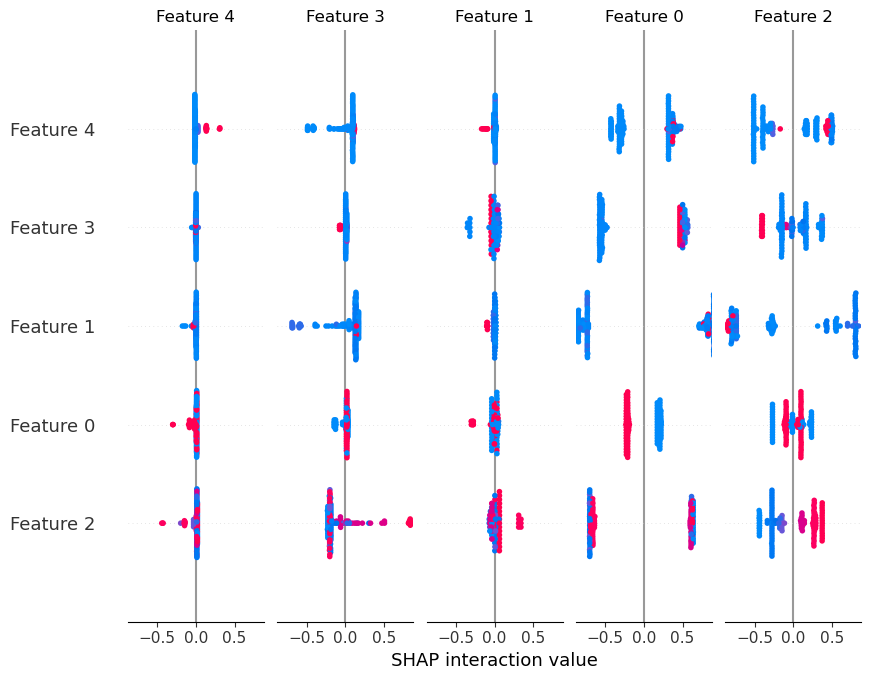

In [164]:

# 输出SHAP值的摘要
# shap.force_plot(explainer.expected_value, shap_values, X_test)
# shap.plots.force(explainer.expected_value, shap_values)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# shap.image_plot(shap_values, -X_test)
shap_values_first_sample_first_class = shap_values[0, 0, :]



In [162]:
# def model_predict(x):
#     x = x.unsqueeze(1)  # 假设模型期望batch_size=1的输入
#     model.eval()
#     with torch.no_grad():
#         output = model(x)
#     return output.numpy()
# background = X_train

# # 创建SHAP解释器
# explainer = shap.Explainer(model_predict, background)

# # 选择一个数据点进行SHAP分析
# data_point = X_train[0]

# # 计算SHAP值
# shap_values = explainer(data_point)

# # 输出SHAP值
# print("SHAP values:", shap_values)

# # 可视化SHAP值（如果数据维度不高，可以使用shap.summary_plot等函数）
# shap.summary_plot(shap_values, data_point)

DimensionError: The passed data does not match the background shape expected by the masker! The data of shape () was passed while the masker expected data of shape (21,).